In [2]:
import sys
dirname = '/Users/muhammaddaffarobani/Documents/personal_research/smt'
if dirname not in sys.path:
    sys.path.append(dirname)
    
from smt.utils.design_space import (
    DesignSpace,
    FloatVariable,
    CategoricalVariable,
)
from smt.applications.mixed_integer import (
    MixedIntegerKrigingModel,
)
from smt.surrogate_models import (
    KPLS,
    MixIntKernelType,
    MixHrcKernelType,
)
from sklearn.metrics import mean_squared_error
from smt.applications.explainability_tools import (
    PartialDependenceDisplay, 
    PDFeatureImportanceDisplay, 
    PDFeatureInteractionDisplay,
    ShapFeatureImportanceDisplay,
    ShapDisplay,
)

import time
import numpy as np


# Creating the model

In [3]:
# Objective function
def cantilever_deflection(x):
    norm_inertia_vals = [
        0.0833, 0.139, 0.380, 0.0796,
        0.133, 0.363, 0.0859, 0.136,
        0.360, 0.0922, 0.138, 0.369,
    ]
    
    I = int(x[0])
    L = x[1]
    S = x[2]
    norm_inertia = norm_inertia_vals[I]

    E = 200e9
    P = 50e3

    y = (P * L**3) / (3 * E * S**2 * norm_inertia)

    return y

def cantilever_deflection_vectorized(X):
    y = np.zeros(X.shape[0])
    for i in range(X.shape[0]):
        y[i] = cantilever_deflection(X[i, :])
    return y

class GroundTruthModel:
    def predict_values(self, X):
        return cantilever_deflection_vectorized(X)

In [4]:
%%time
"""Problem definition"""
# Design space
ds = DesignSpace([
    CategoricalVariable([
        "type_A", "type_B", "type_C", "type_D", 
        "type_E", "type_F", "type_G", "type_H", 
        "type_I", "type_J", "type_K", "type_L",
    ]),
    FloatVariable(10.0, 20.0),
    FloatVariable(1.0, 2.0),
])
categorical_feature_idx = [0]

f_obj = cantilever_deflection

# Create training and testing data
n_data = 250
n_train = int(0.8 * n_data)
n_test = n_data - n_train
xdoe, _ = ds.sample_valid_x(n_data)
y_doe = [f_obj(xdoe[i]) for i in range(len(xdoe))]

x_ref, _ = ds.sample_valid_x(1000)
y_ref = [f_obj(x_ref[i]) for i in range(len(x_ref))]
X_ref = np.array(x_ref)
y_ref = np.array(y_ref)

X_tr, y_tr = xdoe[:n_train, :], y_doe[:n_train]
X_te, y_te = xdoe[n_train:, :], y_doe[n_train:]
y_tr, y_te = np.array(y_tr), np.array(y_te)

# Name of the features
feature_names = [r'$I$', r'$L$', r'$S$']

# create mapping for the categories
categories_map = dict()
inverse_categories_map = dict()
for feature_idx in categorical_feature_idx:
    categories_map[feature_idx] = {
        i: value for i, value in enumerate(ds._design_variables[feature_idx].values)
    }
    inverse_categories_map[feature_idx] = {
        value: i for value, i in enumerate(ds._design_variables[feature_idx].values)
    }

"""Modelling"""
sm = MixedIntegerKrigingModel(
    surrogate=KPLS(
        design_space=ds,
        categorical_kernel=MixIntKernelType.HOMO_HSPHERE,
        hierarchical_kernel=MixHrcKernelType.ARC_KERNEL,
        theta0=np.array([4.43799547e-04, 4.39993134e-01, 1.59631650e+00]),
        corr="squar_exp",
        n_start=1,
        cat_kernel_comps=[2],
        n_comp=2,
        print_global=False,
        ),
    )


start_time = time.time()
sm.set_training_values(X_tr, np.array(y_tr))
sm.train()
print("run time (s):", time.time() - start_time)

print("Surrogate model")
y_pred = sm.predict_values(X_te)
rmse = mean_squared_error(y_te, y_pred, squared=False)
rrmse = rmse / y_te.mean()
print(f"RMSE: {rmse:.4f}")
print(f"rRMSE: {rrmse:.4f}")

print("Ground truth model")
gtm = GroundTruthModel()
y_pred = gtm.predict_values(X_te)
rmse = mean_squared_error(y_te, y_pred, squared=False)
rrmse = rmse / y_te.mean()
print(f"RMSE: {rmse:.4f}")
print(f"rRMSE: {rrmse:.4f}")

run time (s): 43.870076179504395
Surrogate model
RMSE: 0.0000
rRMSE: 0.0353
Ground truth model
RMSE: 0.0000
rRMSE: 0.0000
CPU times: user 2min 35s, sys: 47 s, total: 3min 22s
Wall time: 52.3 s


# Feature importance

## PDP

Using `PDFeatureImportanceDisplay.from_surrogate_model` method
- Required parameters:
    - model: surrogate model. 
    - X: input spaces as a reference to create the partial dependence plot. 

- Config parameters:
    - categorical_features: list of categorical features index. this is crucial for the computation.
    - feature_names: name of the features for the axis. 
    - sorted: if True, sort the features based on the feature importance. 

CPU times: user 7min 56s, sys: 1min 58s, total: 9min 55s
Wall time: 2min 51s


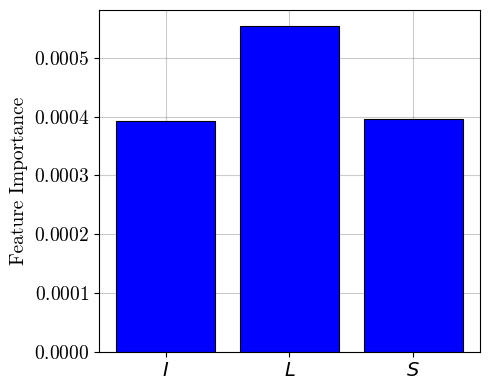

In [5]:
%%time
model = sm
X = X_tr

feature_importance = PDFeatureImportanceDisplay.from_surrogate_model(
    model, 
    X, 
    categorical_features=categorical_feature_idx,
    feature_names=feature_names,
)

## SHAP

Using `ShapFeatureImportanceDisplay.from_surrogate_model` method
- Required parameters:
    - model: surrogate model. 
    - X: input spaces as a reference to create the partial dependence plot. 

- Config parameters:
    - categorical_features: list of categorical features index. this is crucial for the computation.
    - feature_names: name of the features for the axis. 
    - sort: if True, sort the features based on the feature importance. 

CPU times: user 1min 16s, sys: 7.11 s, total: 1min 23s
Wall time: 22.1 s


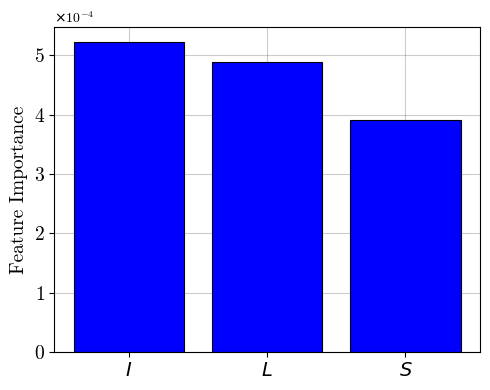

In [6]:
%%time
model = sm
X = X_tr

feature_importance = ShapFeatureImportanceDisplay.from_surrogate_model(
    model, 
    X, 
    feature_names=feature_names,
    categorical_features=categorical_feature_idx,
)

CPU times: user 883 ms, sys: 25.6 ms, total: 909 ms
Wall time: 204 ms


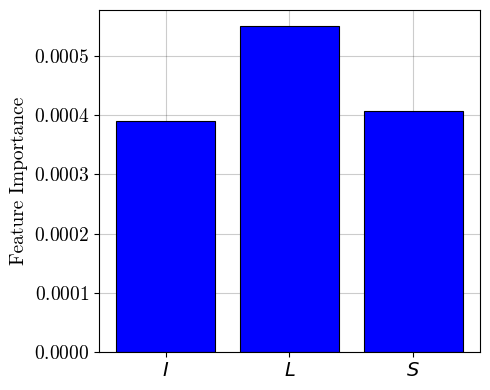

In [7]:
%%time
model = gtm
X = x_ref

feature_importance = PDFeatureImportanceDisplay.from_surrogate_model(
    model, 
    X, 
    categorical_features=categorical_feature_idx,
    feature_names=feature_names,
)

CPU times: user 1.24 s, sys: 145 ms, total: 1.38 s
Wall time: 715 ms


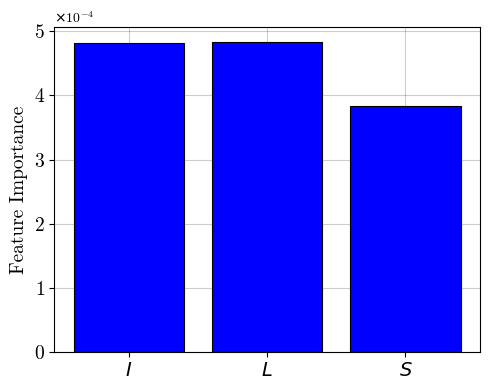

In [8]:
%%time
model = gtm
X = x_ref

feature_importance = ShapFeatureImportanceDisplay.from_surrogate_model(
    model, 
    X, 
    feature_names=feature_names,
    categorical_features=categorical_feature_idx,
)

# Feature interaction

## Overall interaction

Using `PDFeatureInteractionDisplay.overall_interaction` method. 
- Required parameters:
    - model: surrogate model.
    - X: input spaces as a reference to compute the interaction. 

- Config parameters:
    - categorical_features: list of categorical features index. this is crucial for the computation.
    - feature_names: name of the features for the axis. 
    - ratio_samples: ratio of samples to be used for computing the feature interaction. 
    - sorted: if True, sort the features based on the feature importance. 



CPU times: user 42min 56s, sys: 15min 42s, total: 58min 38s
Wall time: 13min 24s


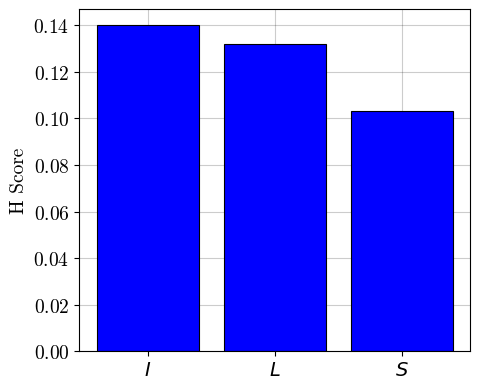

In [9]:
%%time
model = sm
X = X_tr

overall_pd_interaction = PDFeatureInteractionDisplay.overall_interaction(
    model,
    X,
    feature_names=feature_names, 
    categorical_features=categorical_feature_idx,
)

CPU times: user 3.65 s, sys: 25.5 ms, total: 3.67 s
Wall time: 3.53 s


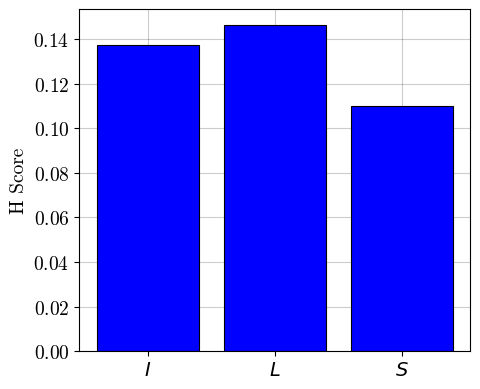

In [10]:
%%time
model = gtm
X = x_ref

overall_pd_interaction = PDFeatureInteractionDisplay.overall_interaction(
    model,
    X,
    feature_names=feature_names, 
    categorical_features=categorical_feature_idx,
)

## Pairwise interaction

Using `PDFeatureInteractionDisplay.pairwise_interaction` method. 
- Required parameters:
    - model: surrogate model.
    - X: input spaces as a reference to compute the interaction. 
    - feature_pairs: pair of features to compute the interaction

- Config parameters:
    - categorical_features: list of categorical features index. this is crucial for the computation.
    - feature_names: name of the features for the axis. 
    - ratio_samples: ratio of samples to be used for computing the feature interaction. 
    - sorted: if True, sort the features based on the feature importance. 



CPU times: user 32min 57s, sys: 27min 55s, total: 1h 52s
Wall time: 9min 15s


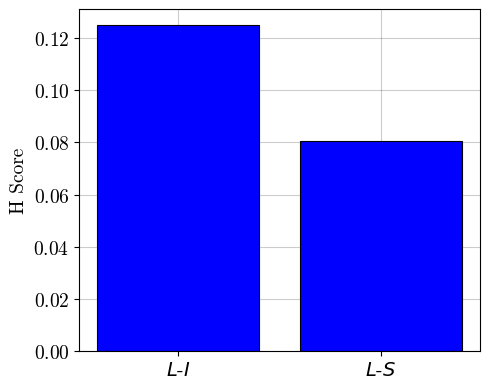

In [11]:
%%time
model = sm
X = X_tr
features = [i for i in range(X_tr.shape[1])]
feature_i = 1
feature_pairs = [
    (feature_i, feature_j) for feature_j in features if feature_j != feature_i
]

pairwise_pd_interaction = PDFeatureInteractionDisplay.pairwise_interaction(
    model,
    X,
    feature_pairs,
    categorical_features=categorical_feature_idx,
    feature_names=feature_names,
)

CPU times: user 3.98 s, sys: 236 ms, total: 4.22 s
Wall time: 3.49 s


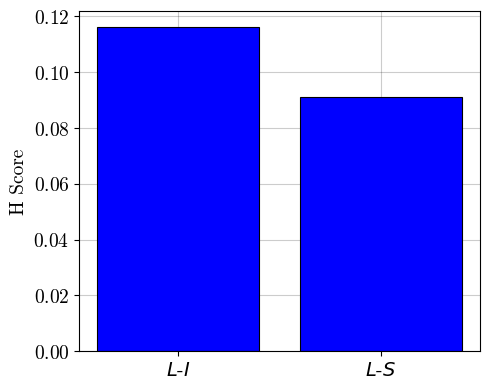

In [12]:
%%time
model = gtm
X = x_ref
features = [i for i in range(X_tr.shape[1])]
feature_i = 1
feature_pairs = [
    (feature_i, feature_j) for feature_j in features if feature_j != feature_i
]

pairwise_pd_interaction = PDFeatureInteractionDisplay.pairwise_interaction(
    model,
    X,
    feature_pairs,
    categorical_features=categorical_feature_idx,
    feature_names=feature_names,
)

# Dependence plot

## 1 Dimension

### PDP

Using `PartialDependenceDisplay.from_surrogate_model` method
- Required parameters:
    - model: surrogate model. 
    - X: input spaces as a reference to create the partial dependence plot. 
    - features: list of feature indexes to create the partial dependence plot on, i.e., y vs x_{i}.

- Config parameters:
    - kind: "average" for creating average dependence plot, "individual" for creating individual plots, "both" for plotting average and individual.
    - centered: if True, the partial dependence plot starts from zero. 
    - grid_resolution: Resolution of the numeric feature values. 
    - categorical features: list of categorical features index. 
    - inverse_categories_map: dictionary to map the integer encoded values of categorical features to its actual values. 
    - feature_names: name of the features for the axis. 
    - percentiles: start and end percentile of each feature when creating the plot. 


CPU times: user 1min 29s, sys: 1min 3s, total: 2min 32s
Wall time: 20.7 s


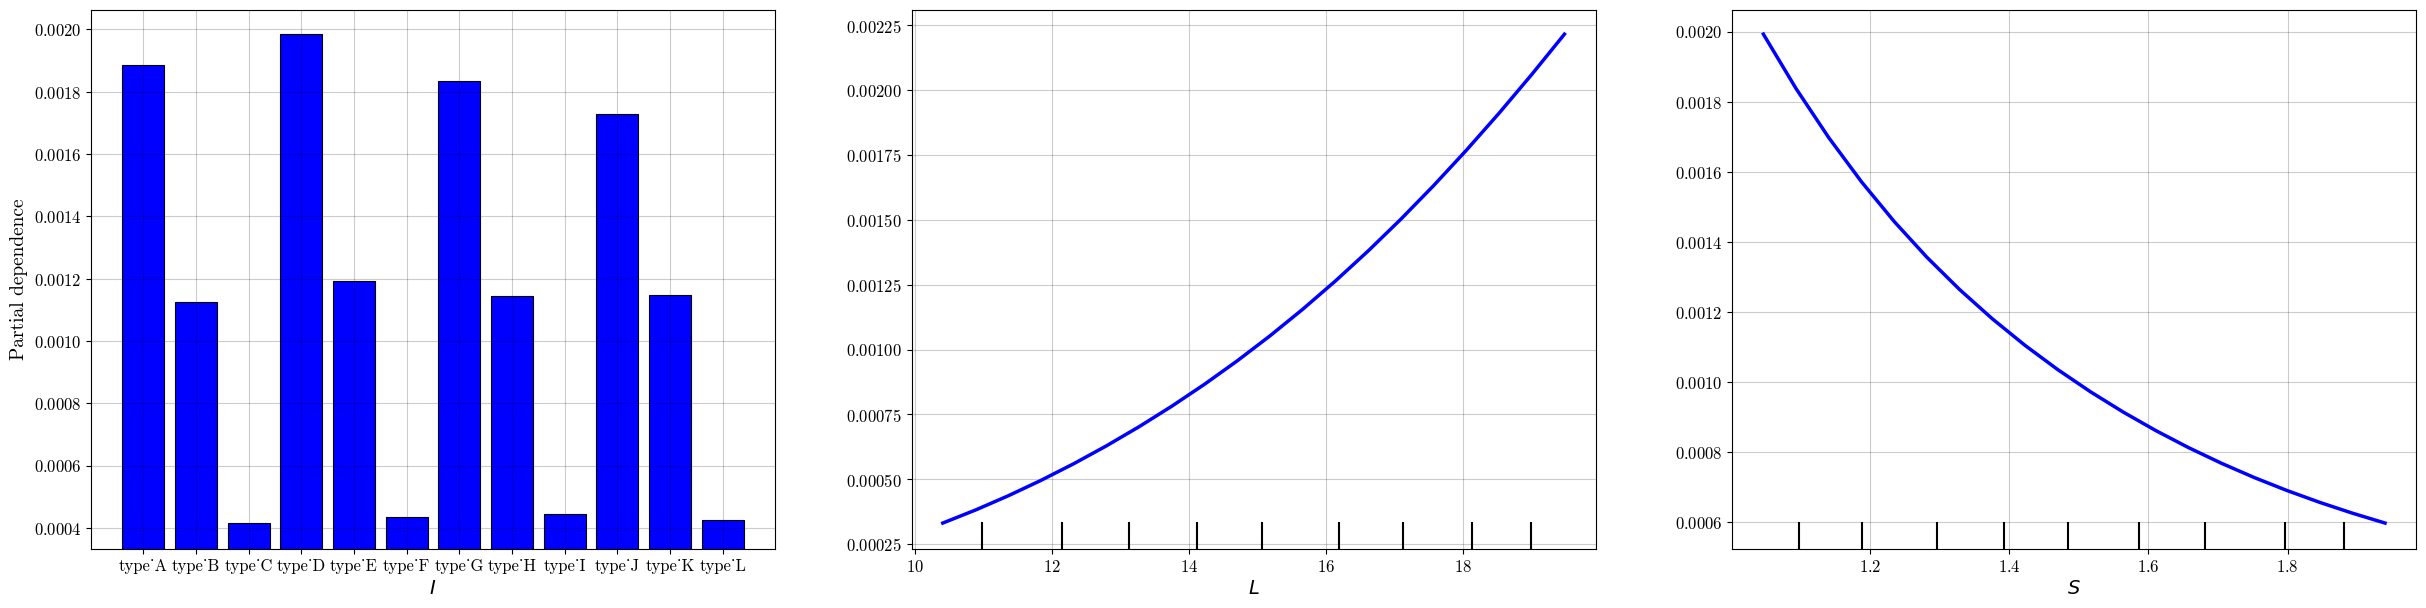

In [13]:
%%time
model = sm
X = X_tr
features = [i for i in range(X_tr.shape[1])]

pdd = PartialDependenceDisplay.from_surrogate_model(
    model, 
    X, 
    features, 
    categorical_features=categorical_feature_idx, 
    feature_names=feature_names,
    grid_resolution=20,
    kind='average',
    centered=False,
    figsize=[30, 7],
    inverse_categories_map=inverse_categories_map,
    )

CPU times: user 1min 31s, sys: 1min 1s, total: 2min 32s
Wall time: 21.1 s


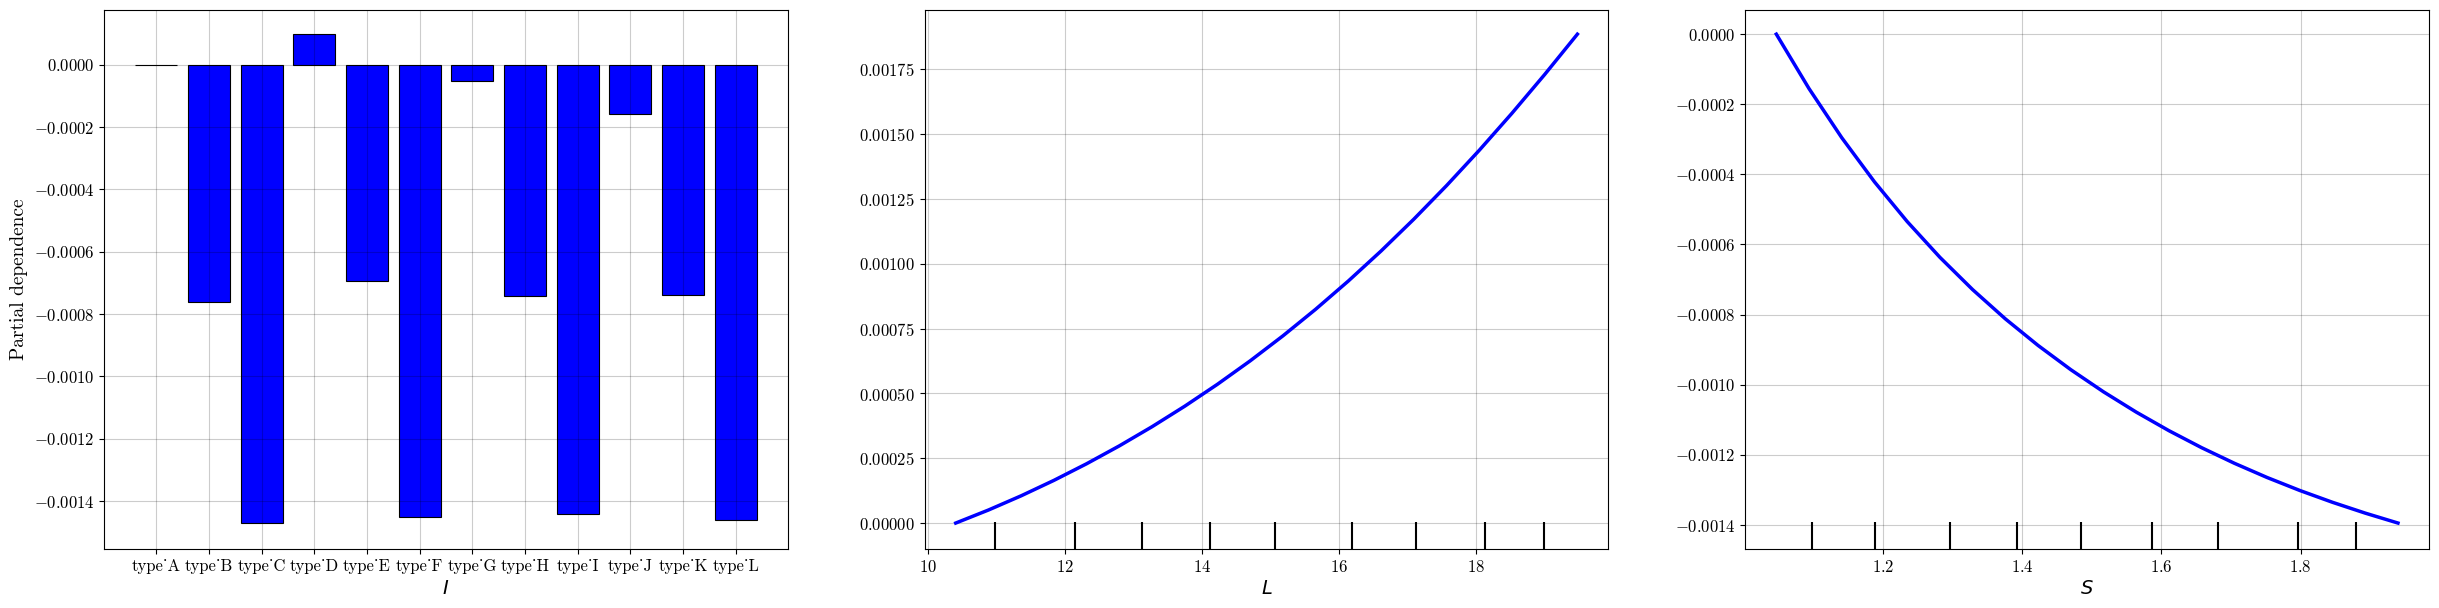

In [14]:
%%time
model = sm
X = X_tr
features = [i for i in range(X_tr.shape[1])]

pdd = PartialDependenceDisplay.from_surrogate_model(
    model, 
    X, 
    features, 
    categorical_features=categorical_feature_idx, 
    feature_names=feature_names,
    grid_resolution=20,
    kind='average',
    centered=True,
    figsize=[30, 7],
    inverse_categories_map=inverse_categories_map,
    )

CPU times: user 1min 36s, sys: 56.6 s, total: 2min 32s
Wall time: 21.2 s


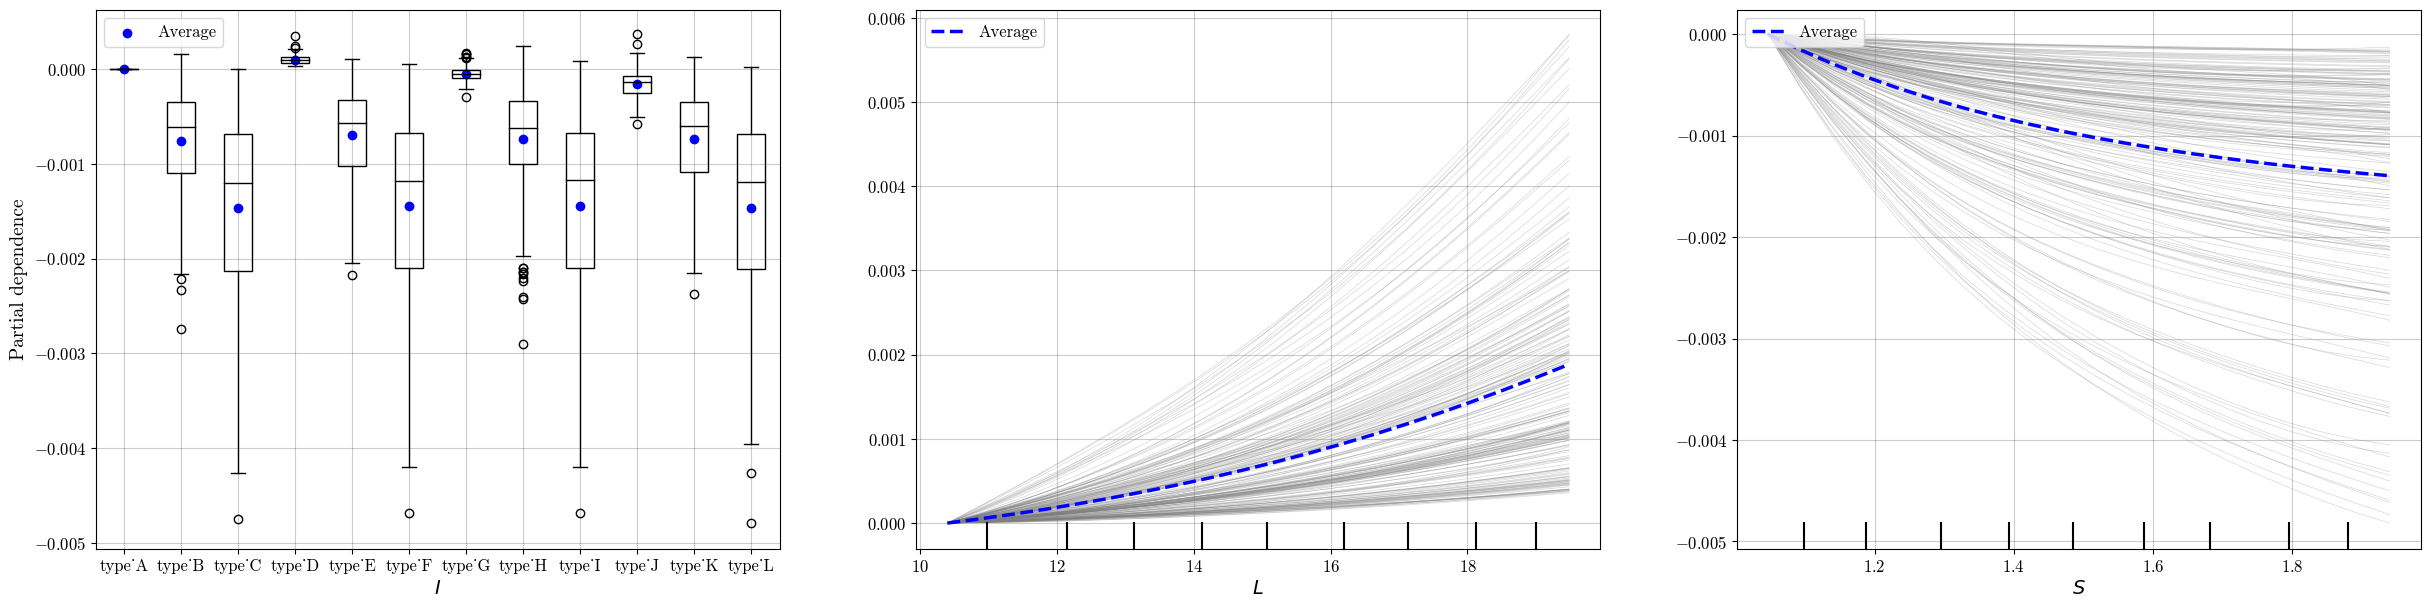

In [15]:
%%time
model = sm
X = X_tr
features = [i for i in range(X_tr.shape[1])]

pdd = PartialDependenceDisplay.from_surrogate_model(
    model, 
    X, 
    features, 
    categorical_features=categorical_feature_idx, 
    feature_names=feature_names,
    grid_resolution=20,
    kind='both',
    centered=True,
    figsize=[30, 7],
    inverse_categories_map=inverse_categories_map,
    )

CPU times: user 177 ms, sys: 2.4 ms, total: 179 ms
Wall time: 178 ms


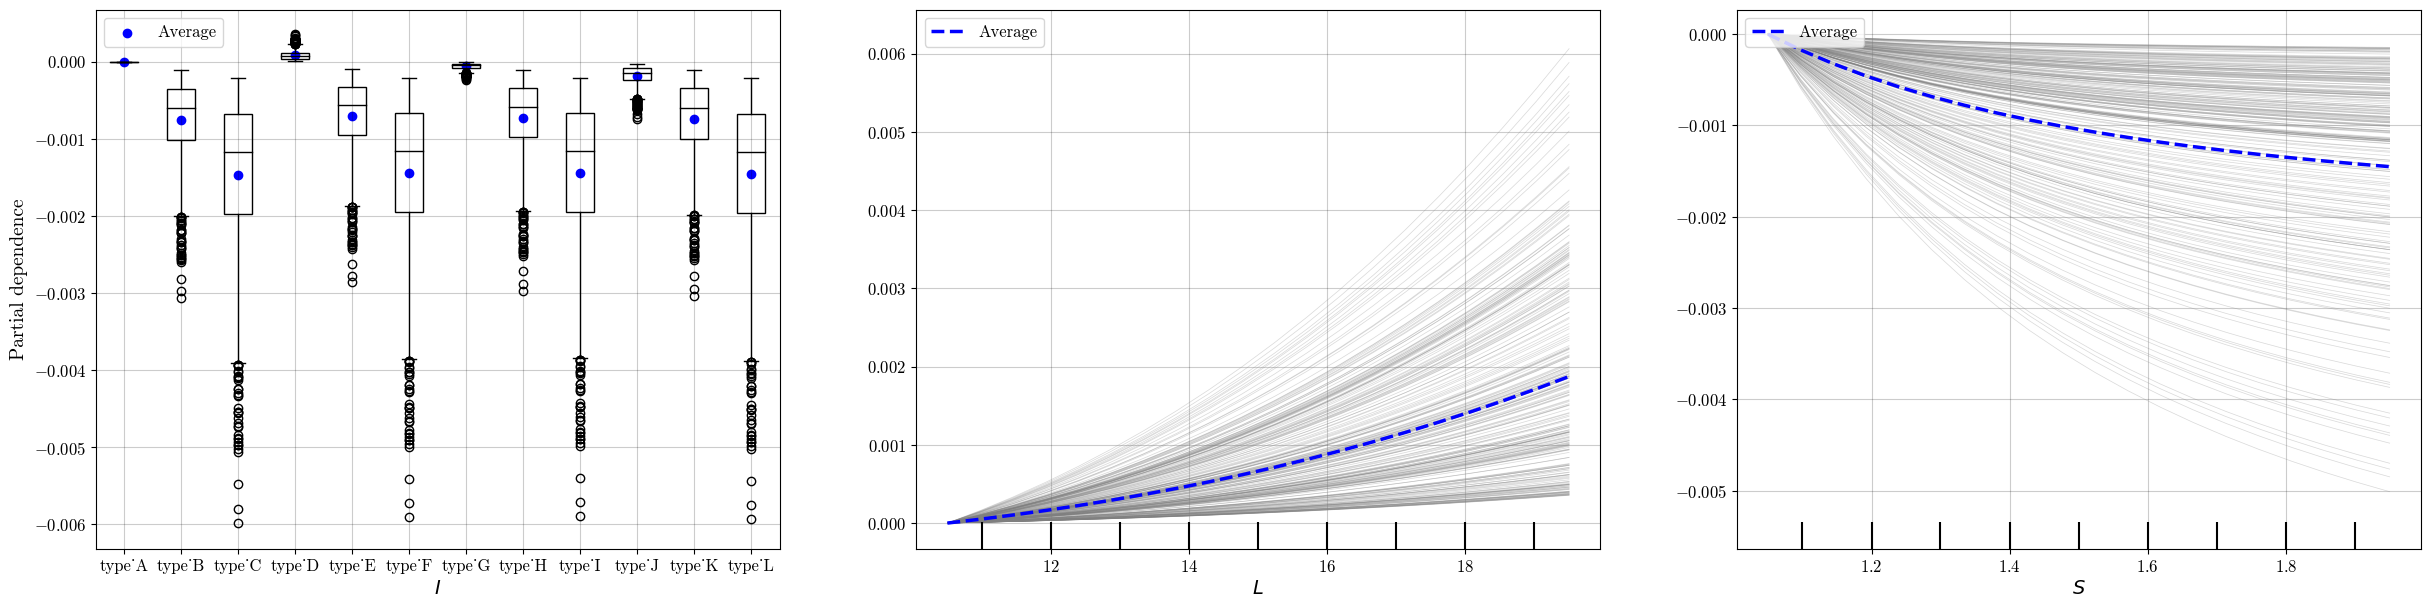

In [16]:
%%time
model = gtm
X = x_ref
features = [i for i in range(X_tr.shape[1])]

pdd = PartialDependenceDisplay.from_surrogate_model(
    model, 
    X, 
    features, 
    categorical_features=categorical_feature_idx, 
    feature_names=feature_names,
    grid_resolution=20,
    kind='both',
    centered=True,
    figsize=[30, 7],
    inverse_categories_map=inverse_categories_map,
    )

### SHAP

In [17]:
%%time
instances = X_tr
model = sm
X = X_tr

explainer_train = ShapDisplay.from_surrogate_model(
    instances, 
    model, 
    X, 
    feature_names=feature_names,
    categorical_features=categorical_feature_idx,
    categories_map=categories_map,
)

CPU times: user 42.5 s, sys: 4.01 s, total: 46.5 s
Wall time: 6.45 s


In [18]:
%%time
model = gtm
X = x_ref

explainer_train_true_ = ShapDisplay.from_surrogate_model(
    X_tr, 
    model, 
    X, 
    feature_names=feature_names,
    categorical_features=categorical_feature_idx,
    categories_map=categories_map,
)
explainer_train_true = ShapDisplay.from_surrogate_model(
    x_ref, 
    model, 
    X, 
    feature_names=feature_names,
    categorical_features=categorical_feature_idx,
    categories_map=categories_map,
)

CPU times: user 1.55 s, sys: 396 ms, total: 1.95 s
Wall time: 345 ms


CPU times: user 472 ms, sys: 10.5 ms, total: 482 ms
Wall time: 160 ms


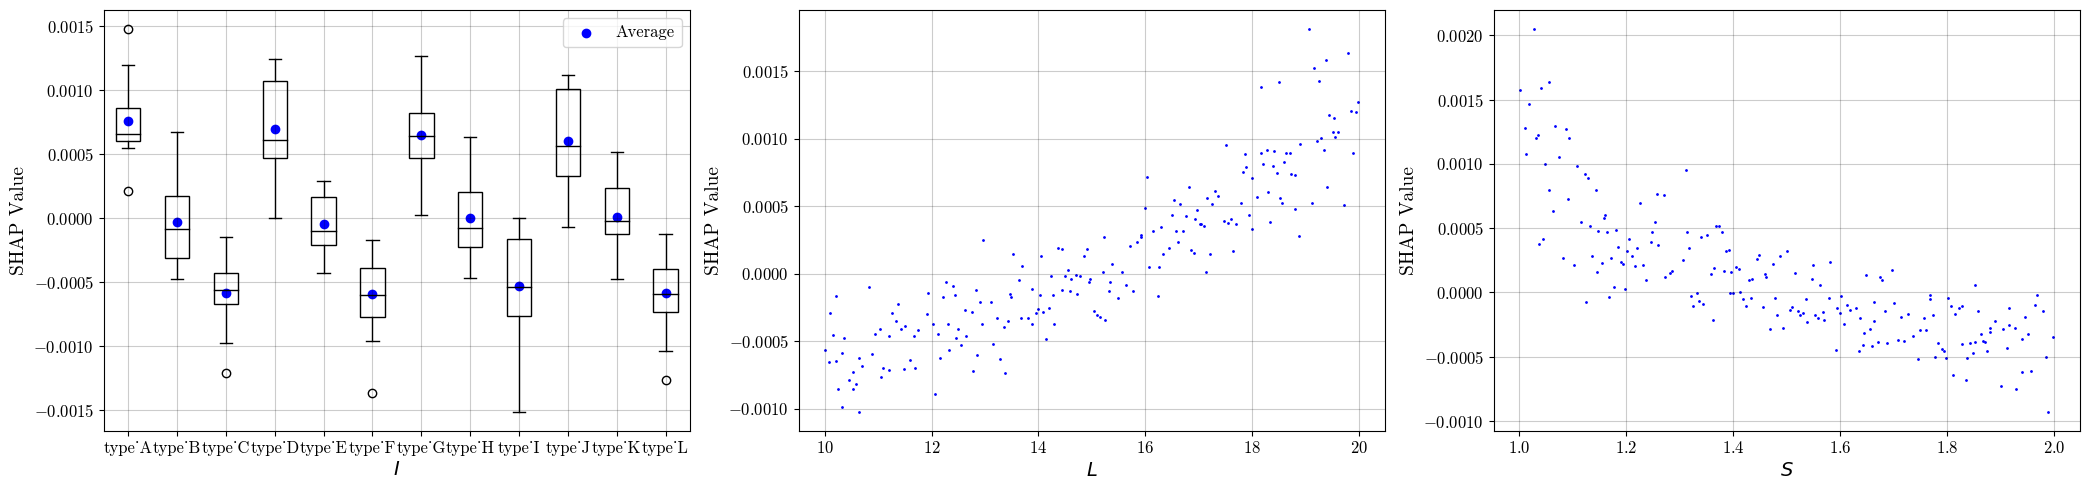

In [19]:
%%time
features = [i for i in range(X_tr.shape[1])]

explainer_train.dependence_plot(features, sort_based_on_importance=False)

CPU times: user 623 ms, sys: 5.51 ms, total: 629 ms
Wall time: 254 ms


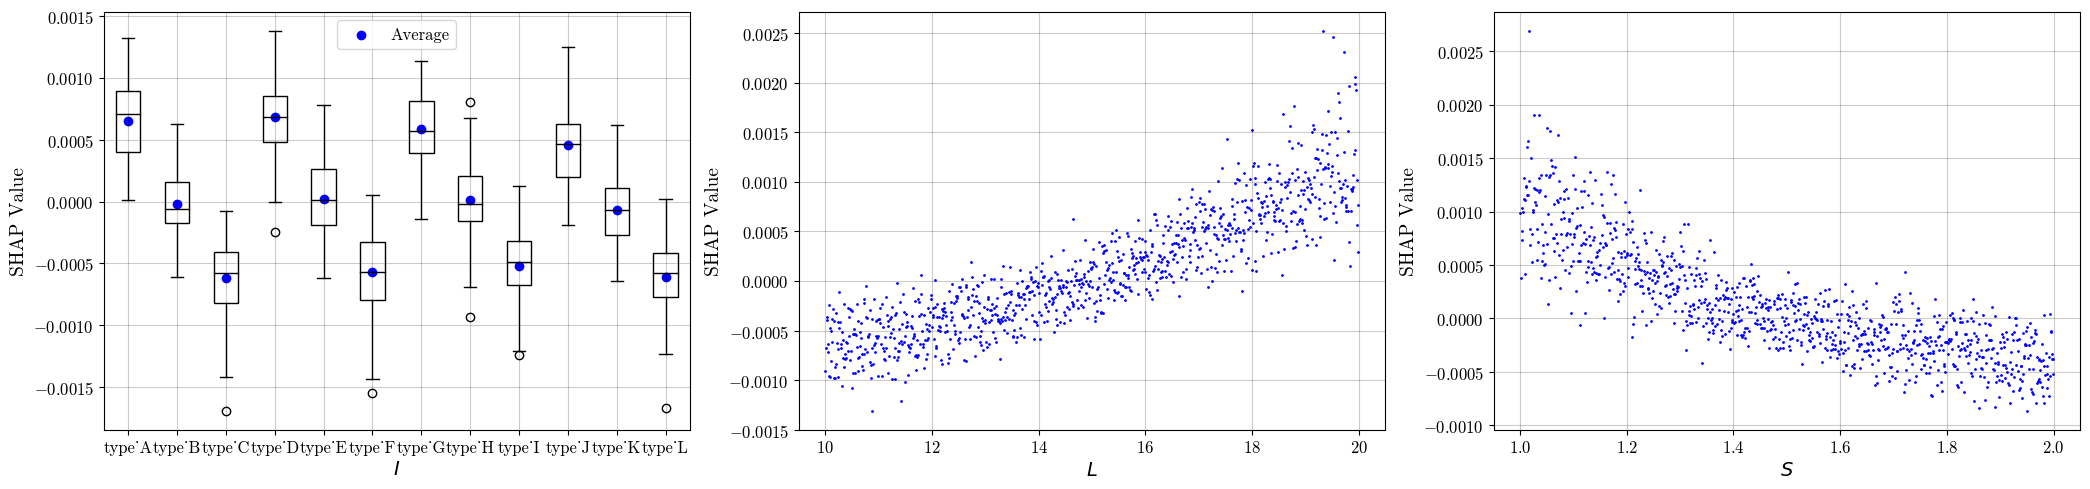

In [20]:
%%time
features = [i for i in range(X_tr.shape[1])]

explainer_train_true.dependence_plot(features, sort_based_on_importance=False)

## 2 Dimension

### PDP

Using `PartialDependenceDisplay.from_surrogate_model` method
- Required parameters:
    - model: surrogate model. 
    - X: input spaces as a reference to create the partial dependence plot. 
    - features: list of feature index pairs to create the partial dependence plot on, i.e., y vs (x_{i}, x_{j})

- Config parameters:
    - centered: if True, the partial dependence plot starts from zero. 
    - grid_resolution: Resolution of the feature values. 
    - feature_names: name of the features for the axis. 
    - percentiles: start and end percentile of each feature when creating the plot. 

CPU times: user 17min 11s, sys: 14min 35s, total: 31min 47s
Wall time: 4min 16s


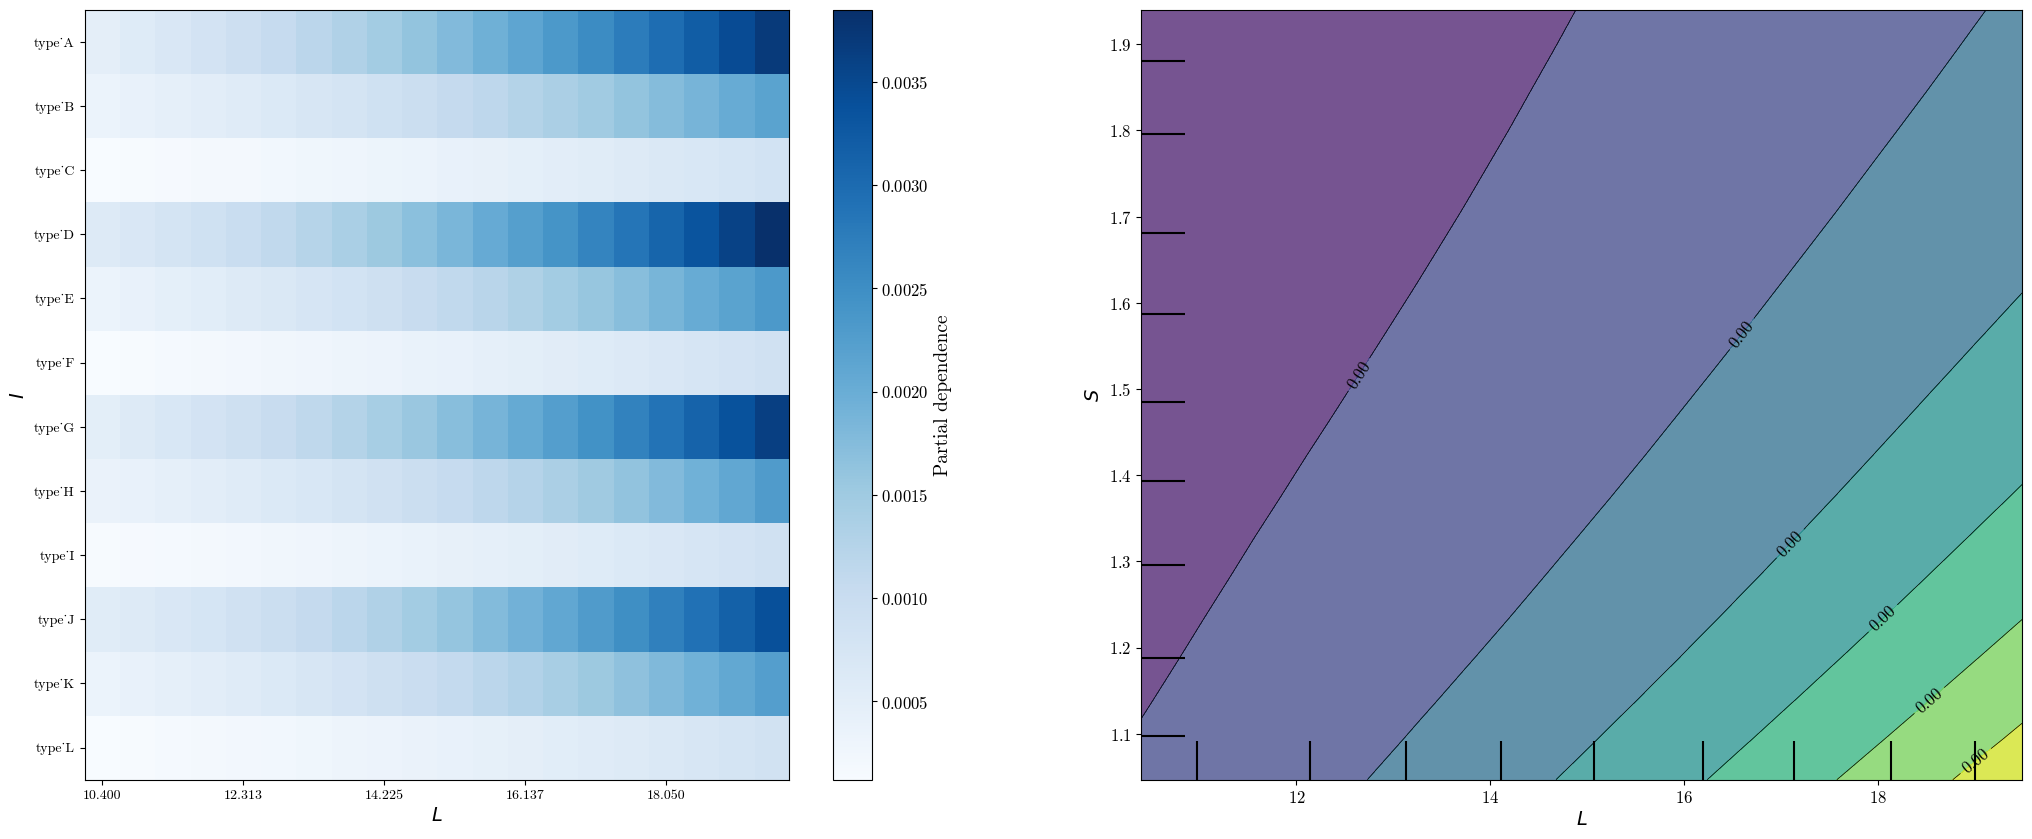

In [21]:
%%time
model = sm
X = X_tr
features = [(0, 1), (1, 2,)]
categorical_features = categorical_feature_idx

pdd = PartialDependenceDisplay.from_surrogate_model(
    model, 
    X, 
    features, 
    categorical_features=categorical_features, 
    feature_names=feature_names,
    grid_resolution=20,
    kind='both',
    centered=False,
    figsize=[25, 10],
    inverse_categories_map=inverse_categories_map,
    )

CPU times: user 399 ms, sys: 2.97 ms, total: 402 ms
Wall time: 402 ms


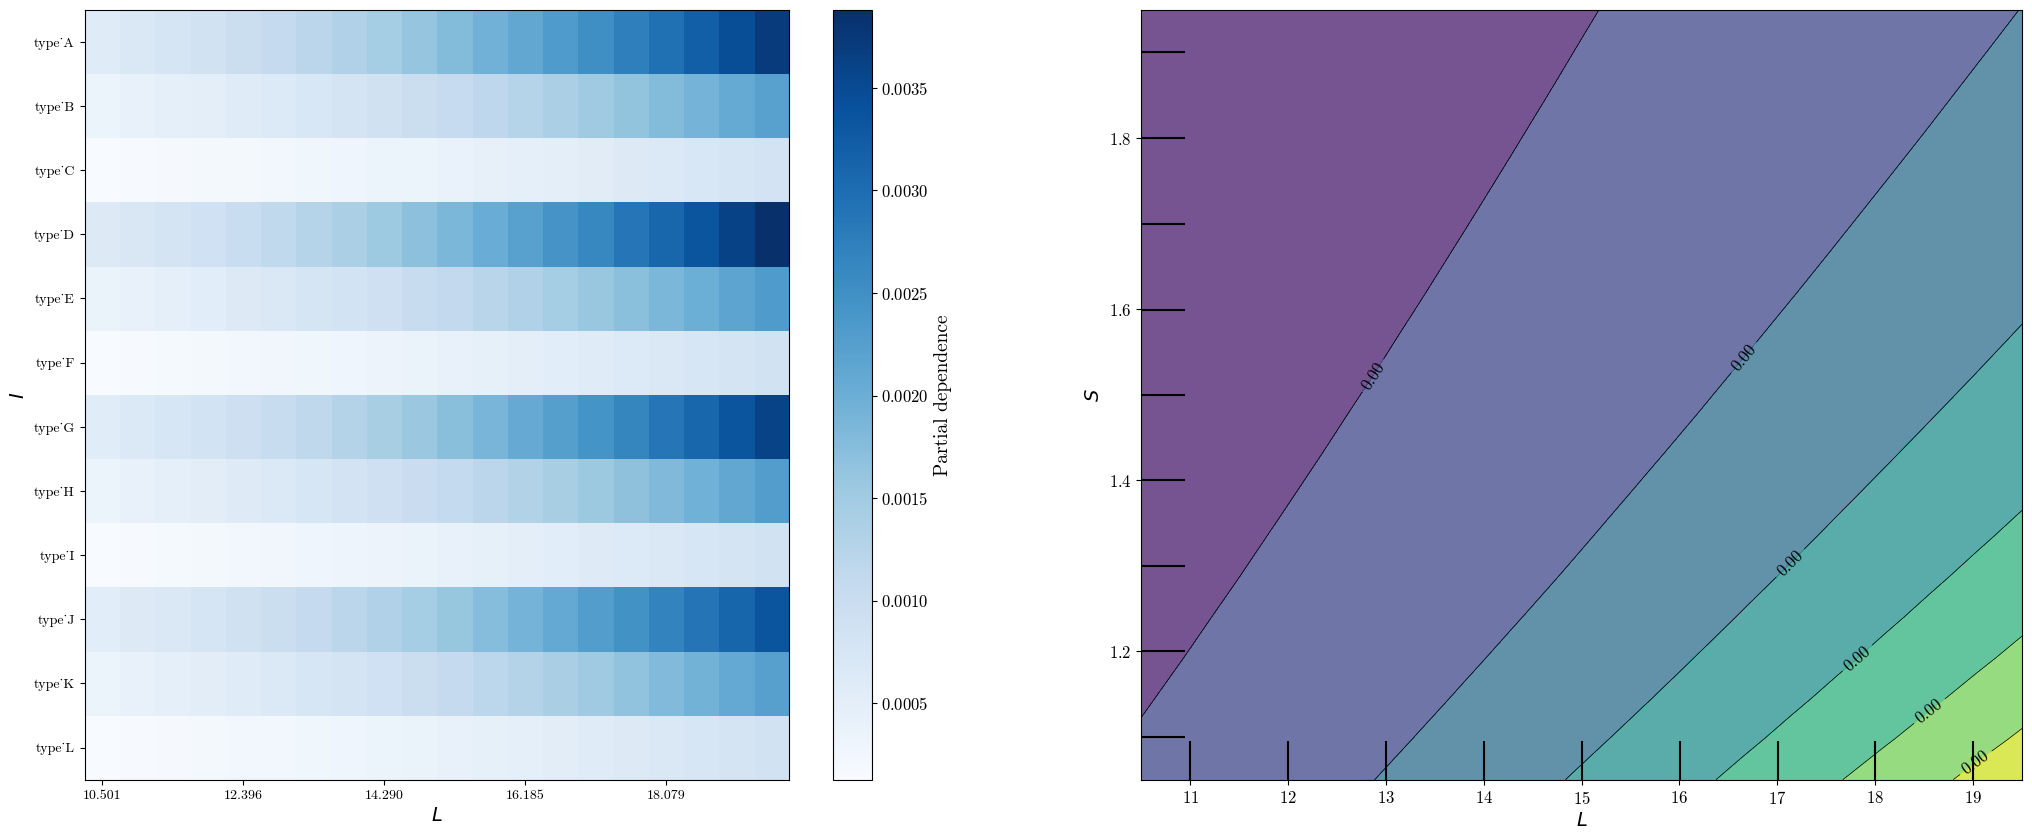

In [22]:
%%time
model = gtm
X = x_ref
features = [(0, 1), (1, 2,)]
categorical_features = categorical_feature_idx

pdd = PartialDependenceDisplay.from_surrogate_model(
    model, 
    X, 
    features, 
    categorical_features=categorical_features, 
    feature_names=feature_names,
    grid_resolution=20,
    kind='both',
    centered=False,
    figsize=[25, 10],
    inverse_categories_map=inverse_categories_map,
    )

CPU times: user 1min 47s, sys: 41.9 s, total: 2min 29s
Wall time: 19.8 s


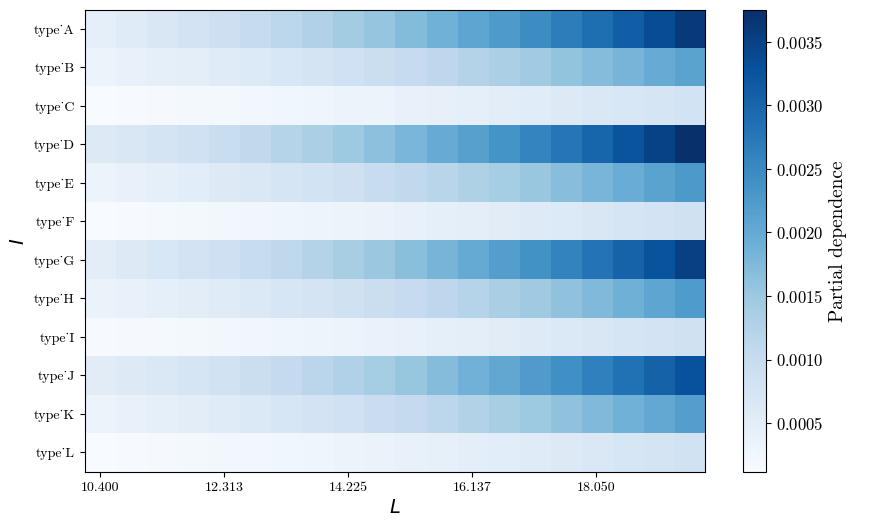

In [23]:
%%time
model = sm
X = X_tr
features = [(0, 1)]
categorical_features = categorical_feature_idx

pdd = PartialDependenceDisplay.from_surrogate_model(
    model, 
    X, 
    features, 
    categorical_features=categorical_features, 
    feature_names=feature_names,
    grid_resolution=20,
    kind='both',
    centered=False,
    figsize=[10, 6],
    inverse_categories_map=inverse_categories_map,
    ratio_samples=0.2,
    )

### SHAP

CPU times: user 260 ms, sys: 9.22 ms, total: 269 ms
Wall time: 91.2 ms


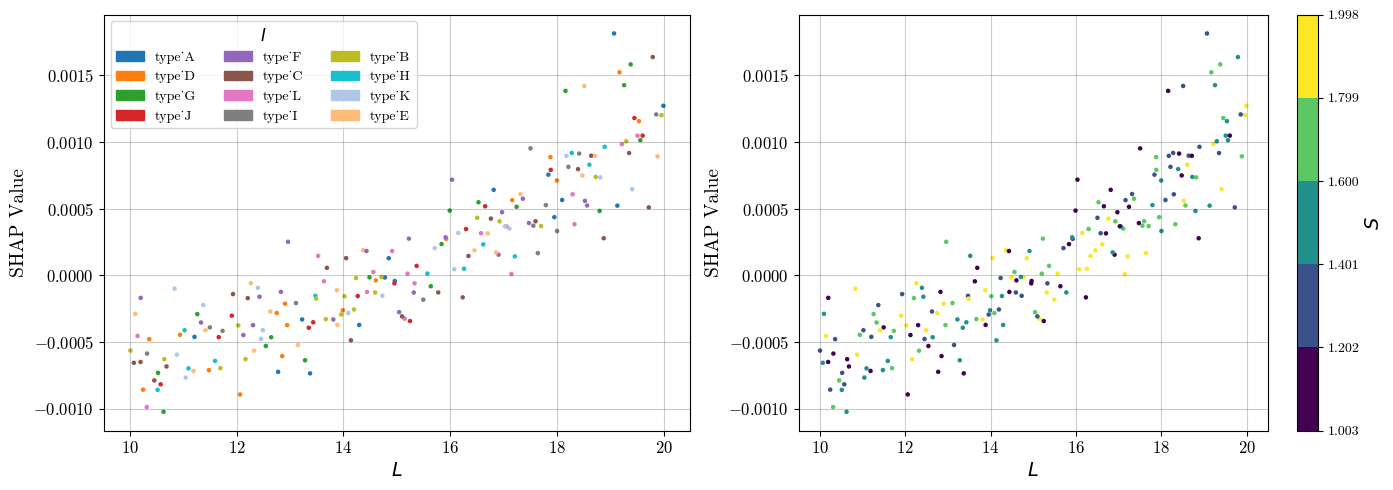

In [24]:
%%time
feature_pairs = [(1, 0), (1, 2)]
explainer_train.interaction_plot(
    feature_pairs, 
    n_color=5,
)

CPU times: user 166 ms, sys: 4.21 ms, total: 170 ms
Wall time: 81.3 ms


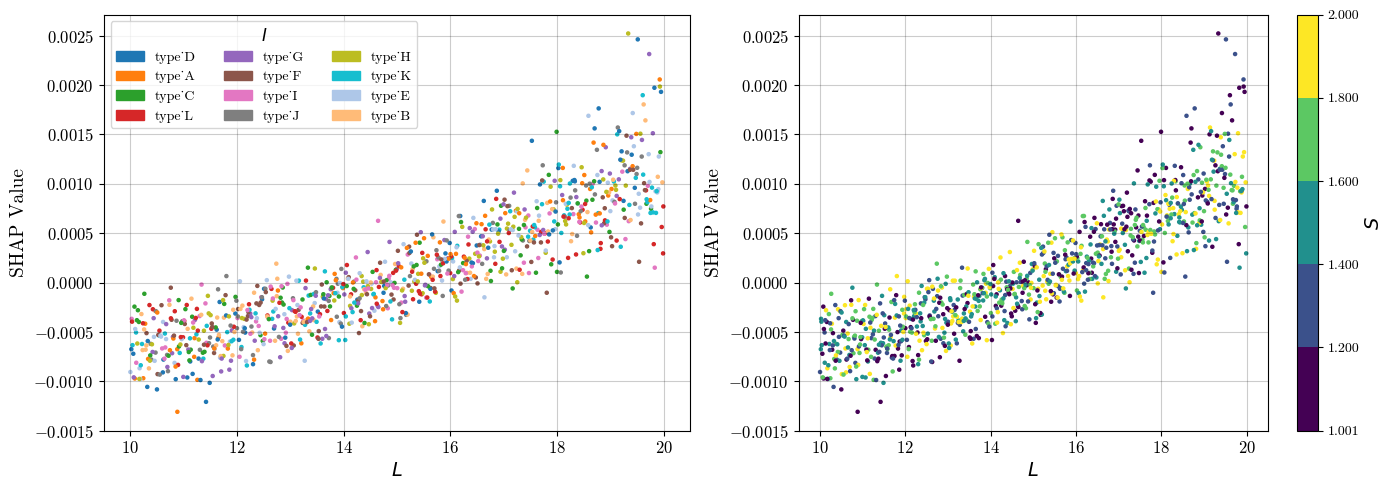

In [25]:
%%time
feature_pairs = [(1, 0), (1, 2)]
explainer_train_true.interaction_plot(
    feature_pairs, 
    n_color=5,
)

CPU times: user 154 ms, sys: 8.88 ms, total: 163 ms
Wall time: 57.9 ms


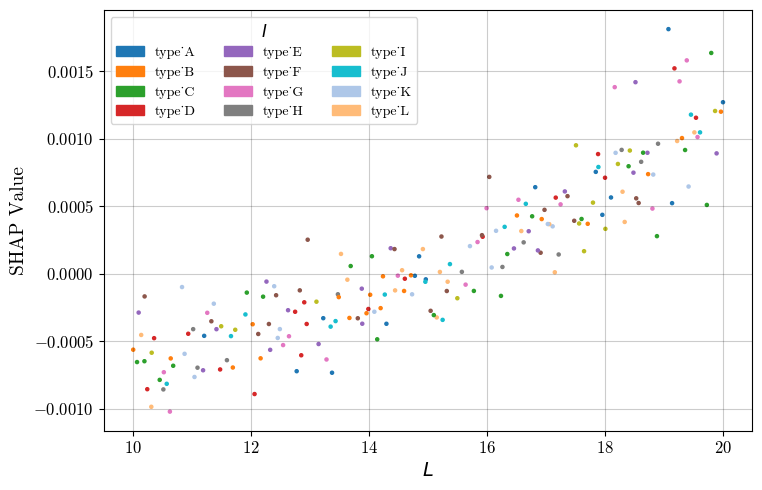

In [26]:
%%time
feature_pairs = [(1, 0)]
explainer_train.interaction_plot(
    feature_pairs, 
    sort_based_on_importance=False,
)

# Other SHAP Plots

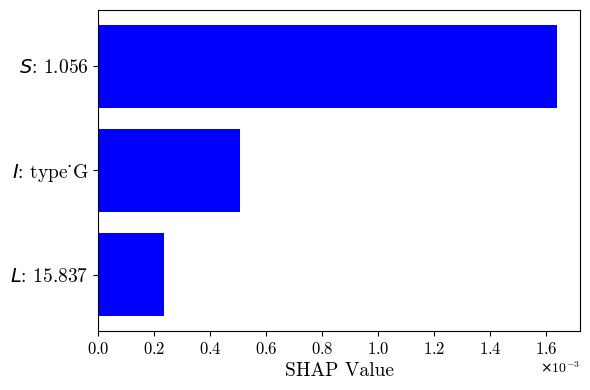

In [27]:
explainer_train.individual_plot(index=2)

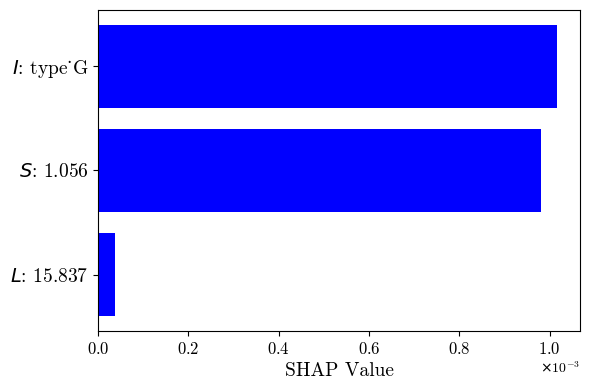

In [28]:
explainer_train_true_.individual_plot(index=2)

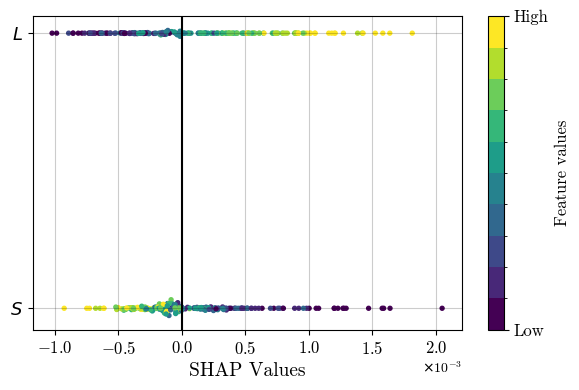

In [29]:
explainer_train.summary_plot()

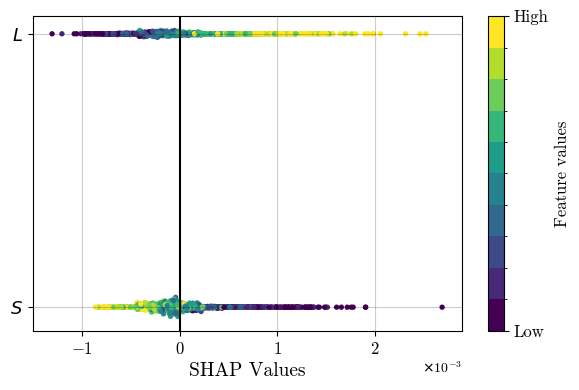

In [30]:
explainer_train_true.summary_plot()

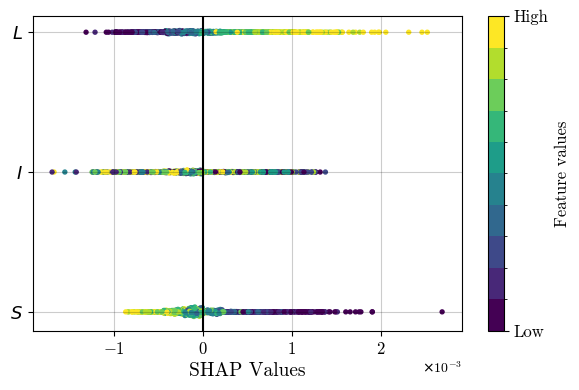

In [32]:
explainer_train_true.summary_plot(include_cat=True)